In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.tree as tree
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from collections import Counter
import re
from sklearn.preprocessing import LabelEncoder

In [2]:
data = pd.read_csv('expedia_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62774 entries, 0 to 62773
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   name                                62774 non-null  object 
 1   current_price                       62774 non-null  float64
 2   reviews_desc                        62774 non-null  int64  
 3   num_reviews                         62774 non-null  float64
 4   breakfast                           62774 non-null  int64  
 5   free_cancellation                   62774 non-null  int64  
 6   grade                               62774 non-null  float64
 7   fully_refundable                    62774 non-null  int64  
 8   reserve_now_pay_later               62774 non-null  int64  
 9   price_after_taxes                   62774 non-null  float64
 10  checkin_date                        62774 non-null  object 
 11  checkout_date                       62774

In [3]:
value_counts = data['num_reviews'].value_counts()
value_counts

num_reviews
1005.0    2259
1004.0    2154
1003.0    1886
1001.0    1832
1002.0    1666
          ... 
3598.0       1
1035.0       1
194.0        1
56.0         1
1125.0       1
Name: count, Length: 584, dtype: int64

In [4]:
# Adding features using existing variables

# Handling the hotel name field
# Creating a LabelEncoder object
label_encoder = LabelEncoder()
# Convert names to numeric identifiers
data['hotel_id'] = label_encoder.fit_transform(data['name'])

def convert_to_date(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d')

data['checkin_date'] = data['checkin_date'].apply(convert_to_date)
#data['checkin_day'] = data['checkin_date'].dt.day

# Adding a feature for the day of the week based on the check-in date
def get_day_of_week(date_obj):
    # Get the day of the week number (0 - Sunday, 1 - Monday, and so on)
    day_of_week = date_obj.weekday()
    return day_of_week

# Replace the values ​​in the 'bed_type' column with the new classification values
data['checkin_day_week'] = data['checkin_date'].apply(get_day_of_week)

In [5]:
def add_all_services_column(data):
    # Define a condition that checks if all services are offered by the hotel
    conditions = (data['reserve_now_pay_later'] == 1) & \
                 (data['fully_refundable'] == 1) & \
                 (data['free_cancellation'] == 1) & \
                 (data['breakfast'] == 1)
    
    # Add the new column with a result of 1 if all conditions are met, otherwise 0
    data['all_services'] = conditions.astype(int)
    return data

# יישום הפונקציה על הנתונים
data = add_all_services_column(data)

# הצגת מספר שורות ראשונות של הדאטה לאחר הוספת העמודה החדשה
data.head()
value_counts = data['all_services'].value_counts()
value_counts

all_services
0    59943
1     2831
Name: count, dtype: int64

Correlations with price:
price               1.000000
hotel_id            0.070692
all_services        0.019982
checkin_day_week   -0.051968
Name: price, dtype: float64


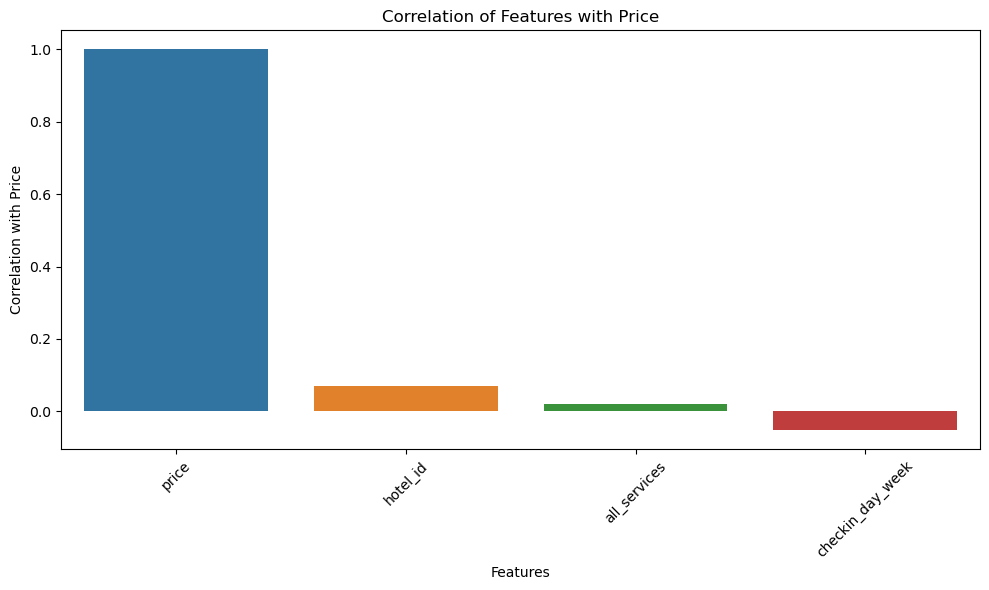

In [6]:
price_correlations = data[['price','all_services',  'checkin_day_week', 'hotel_id']].corr()['price'].sort_values(ascending=False)

print("Correlations with price:")
print(price_correlations)

plt.figure(figsize=(10, 6))
sns.barplot(x=price_correlations.index, y=price_correlations.values)
plt.title('Correlation of Features with Price')
plt.xlabel('Features')
plt.ylabel('Correlation with Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
data = data.drop(['name', 'checkin_date' ,'checkout_date', 'Snapshot Date','current_price','price_after_taxes'], axis=1)
data_wo_features = data.drop([ 'checkin_day_week', 'all_services', 'hotel_id'], axis=1)

In [8]:
data.describe()

reviews_desc   num_reviews     breakfast  free_cancellation  \
count  62774.000000  62774.000000  62774.000000       62774.000000   
mean       2.946188   1465.367588      0.130420           0.468283   
std        1.110829   1022.960264      0.336768           0.498997   
min        1.000000      1.000000      0.000000           0.000000   
25%        2.000000   1002.000000      0.000000           0.000000   
50%        3.000000   1060.000000      0.000000           0.000000   
75%        4.000000   1651.000000      0.000000           1.000000   
max        5.000000   5946.000000      1.000000           1.000000   

              grade  fully_refundable  reserve_now_pay_later           TTT  \
count  62774.000000      62774.000000           62774.000000  62774.000000   
mean       8.694572          0.468283               0.348504     15.206630   
std        0.576195          0.498997               0.476500      8.652064   
min        7.070000          0.000000               0.000000      0.000000   
25%        8.280000          0.000000               0.000000      8.000000   
50%        8.880000          0.000000               0.000000     15.000000   
75%        9.090000          1.000000               1.000000     23.000000   
max        9.890000          1.000000               1.000000     30.000000   

                LOS         order         price      hotel_id  \
count  62774.000000  62774.000000  62774.000000  62774.000000   
mean       2.977347     78.119970   3434.343422    208.572865   
std        1.408512     43.797325   2835.527222    125.403943   
min        1.000000      2.000000    128.000000      0.000000   
25%        2.000000     40.000000   1036.000000    107.000000   
50%        3.000000     78.000000   2685.000000    194.000000   
75%        4.000000    117.000000   5504.000000    308.000000   
max        5.000000    155.000000  12460.000000    432.000000   

       checkin_day_week  all_services  
count      62774.000000  62774.000000  
mean           3.059563      0.045098  
std            2.040696      0.207521  
min            0.000000      0.000000  
25%            1.000000      0.000000  
50%            3.000000      0.000000  
75%            5.000000      0.000000  
max            6.000000      1.000000

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# From the above, it can be seen that the data ranges for the "Number of Reviews"
# variable and the "Distance from Center" variable are different from the rest, 
# so we will normalize them.
columns_to_normalize = [ 'num_reviews']

# Min-Max Scaling
min_max_scaler = MinMaxScaler()
data_min_max_scaled = data.copy()
data_min_max_scaled[columns_to_normalize] = min_max_scaler.fit_transform(data[columns_to_normalize])

# Standardization
standard_scaler = StandardScaler()
data_standard_scaled = data.copy()
data_standard_scaled[columns_to_normalize] = standard_scaler.fit_transform(data[columns_to_normalize])

print("Original Data:")
print(data[columns_to_normalize].head())

print("\nMin-Max Scaled Data:")
print(data_min_max_scaled[columns_to_normalize].head())

print("\nStandard Scaled Data:")
print(data_standard_scaled[columns_to_normalize].head())

Original Data:
   num_reviews
0       1306.0
1       3670.0
2        521.0
3       2625.0
4       3586.0

Min-Max Scaled Data:
   num_reviews
0     0.219512
1     0.617157
2     0.087468
3     0.441379
4     0.603028

Standard Scaled Data:
   num_reviews
0    -0.155792
1     2.155167
2    -0.923179
3     1.133614
4     2.073051


In [10]:
data_wo_features = data_min_max_scaled.drop([ 'checkin_day_week','hotel_id','all_services'], axis=1)

DataFrame: data_min_max_scaled

Test Set Results:
     K  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0    1        5.018290e+05               708.398890           266.100834   
1    3        4.750456e+05               689.235493           382.857254   
2    5        5.212938e+05               722.006790           444.956597   
3   10        6.324681e+05               795.278653           526.943918   
4   50        1.152328e+06              1073.465595           741.148984   
5   80        1.407105e+06              1186.214728           835.763354   
6  200        2.064977e+06              1437.002730          1048.472031   

        R^2  
0  0.937156  
1  0.940510  
2  0.934718  
3  0.920795  
4  0.855693  
5  0.823787  
6  0.741401  
Train Set Results:
     K  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0    1        0.000000e+00                 0.000000             0.000000   
1    3        1.939004e+05               440.341262       

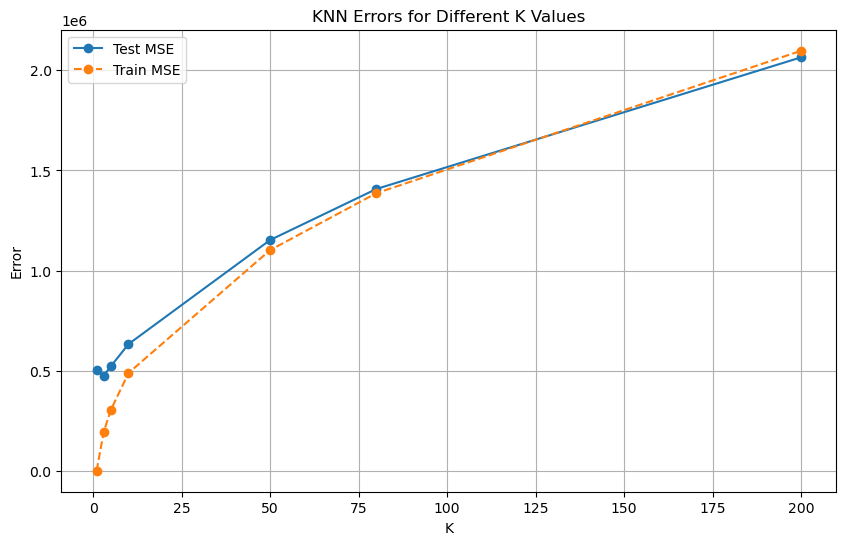

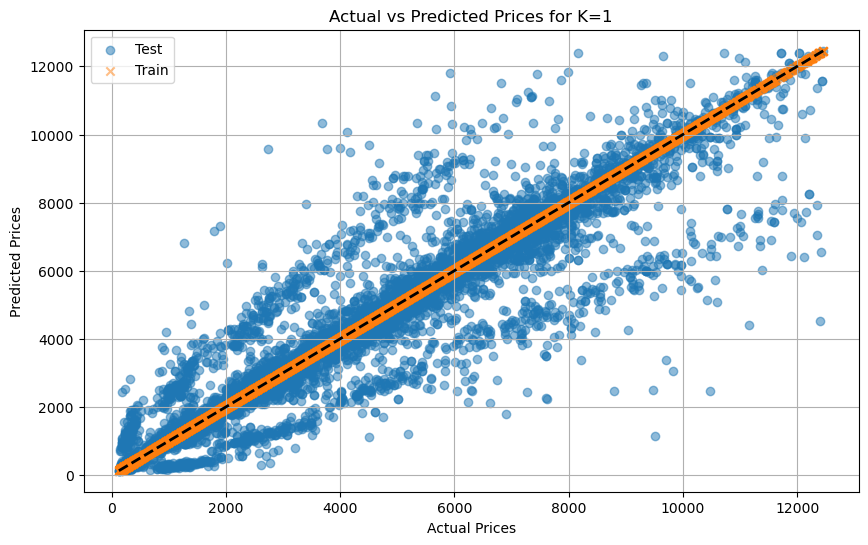

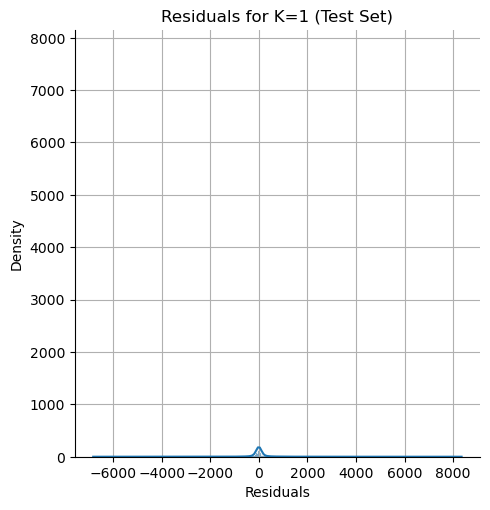

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


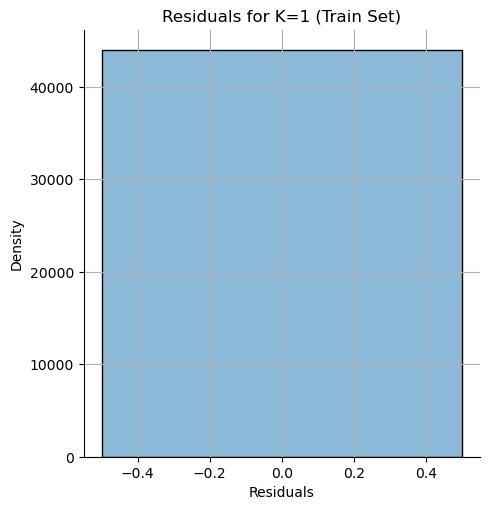

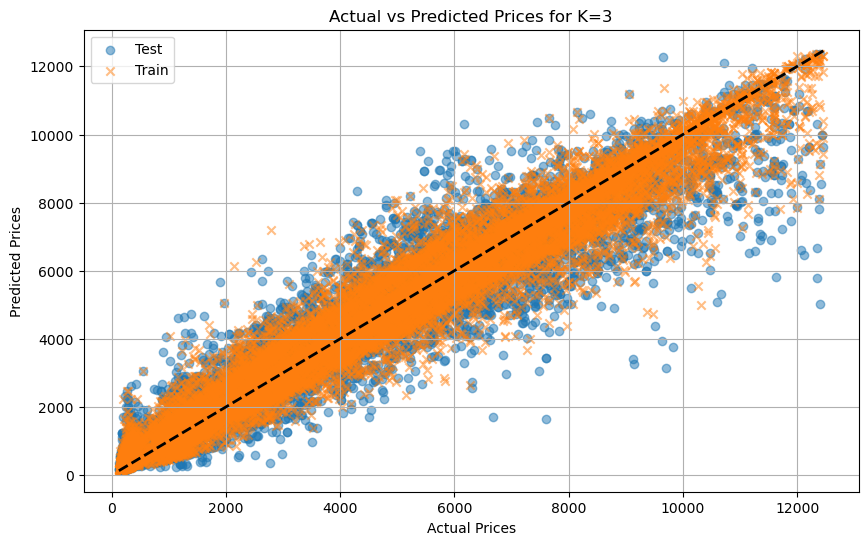

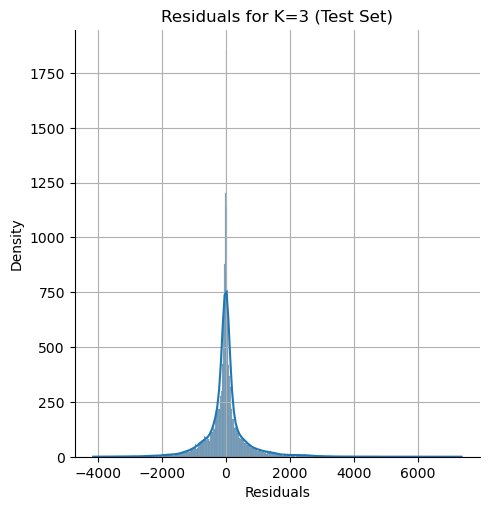

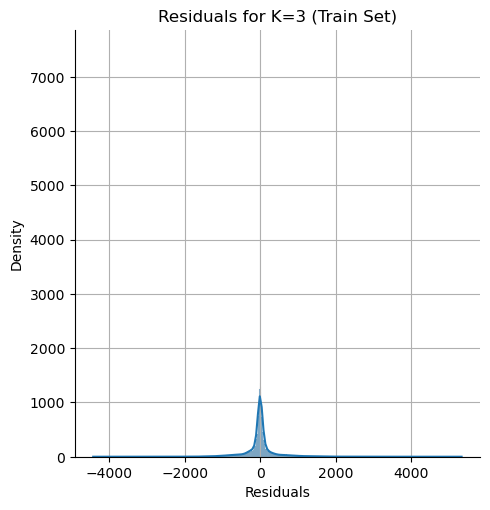

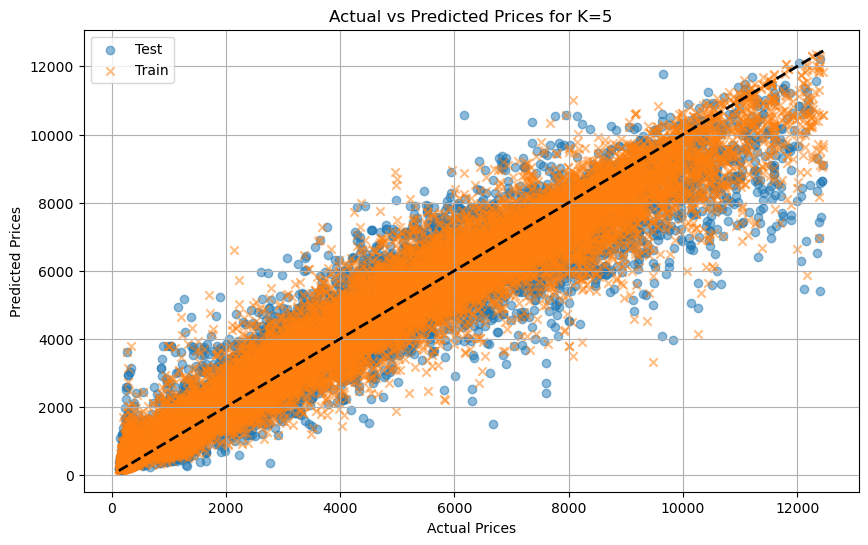

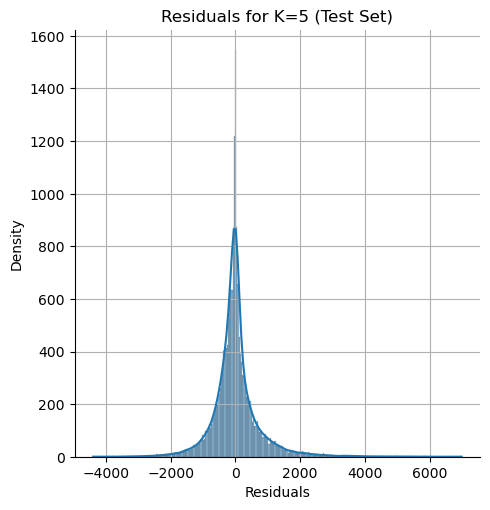

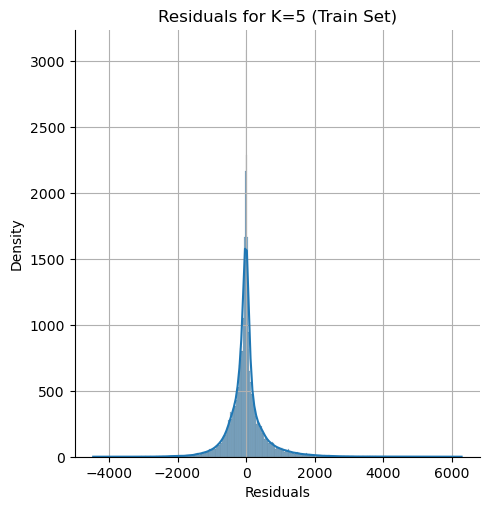

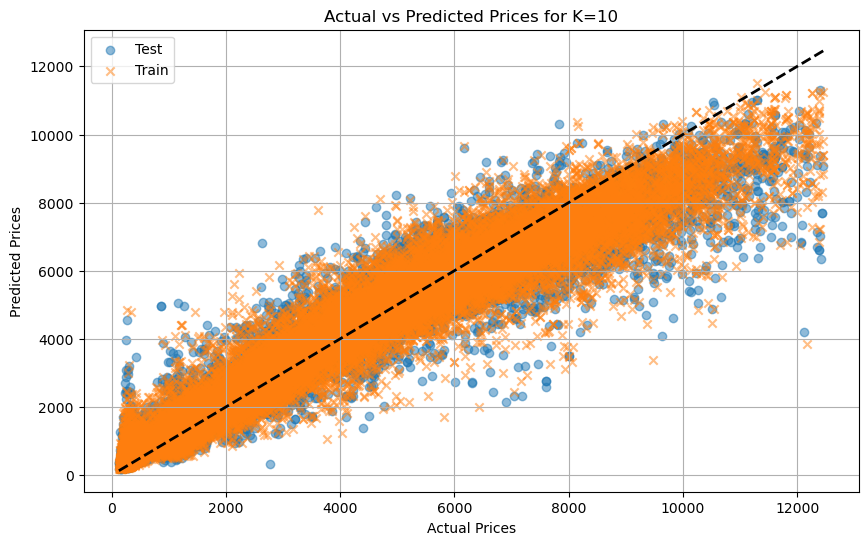

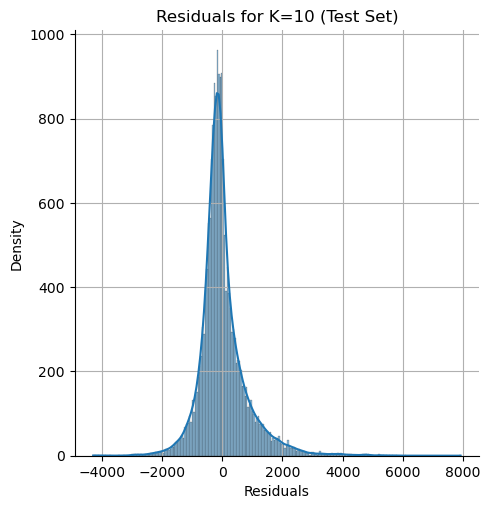

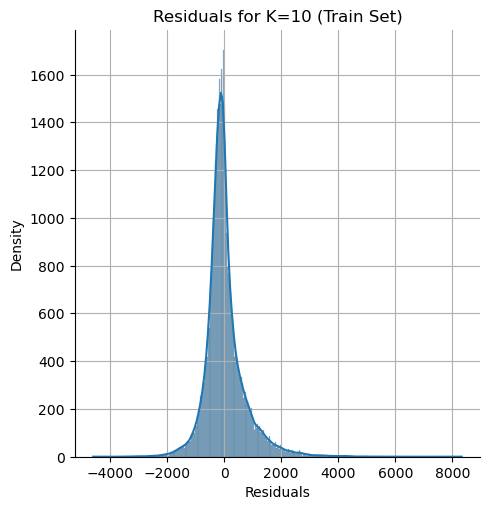

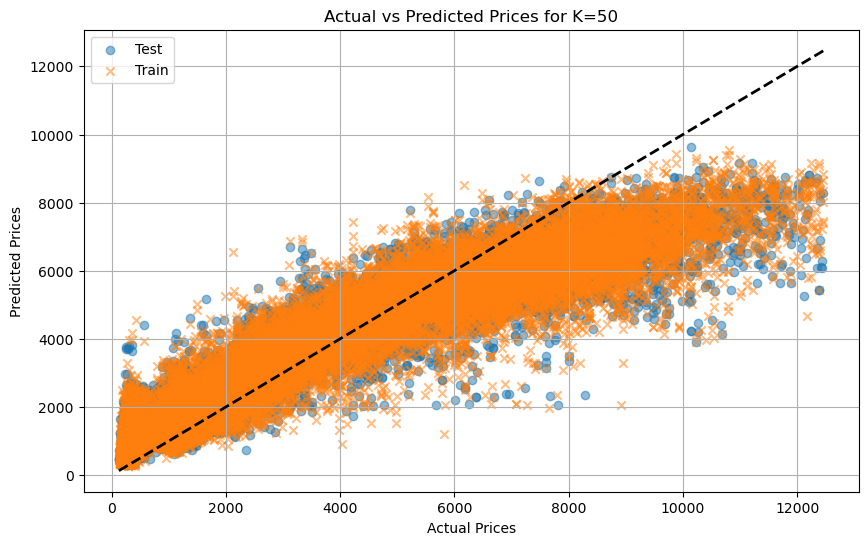

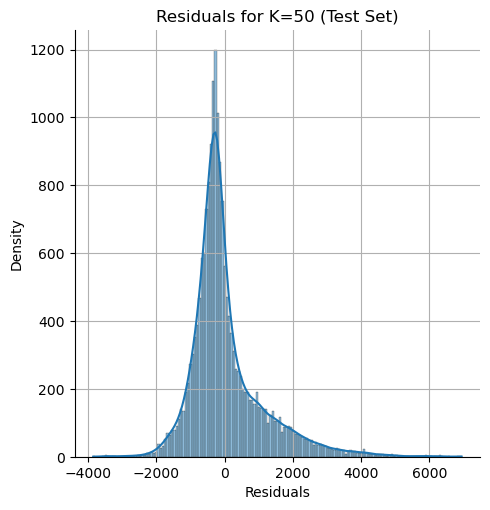

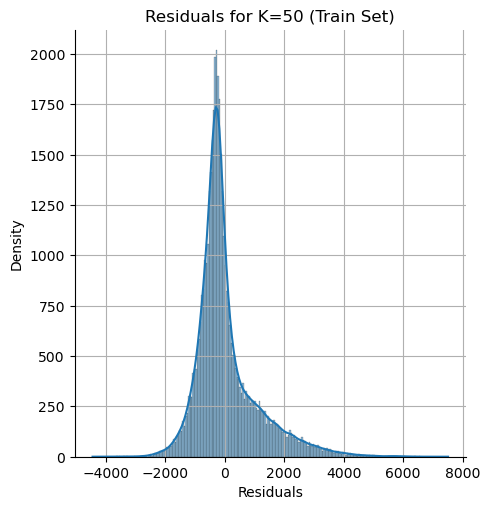

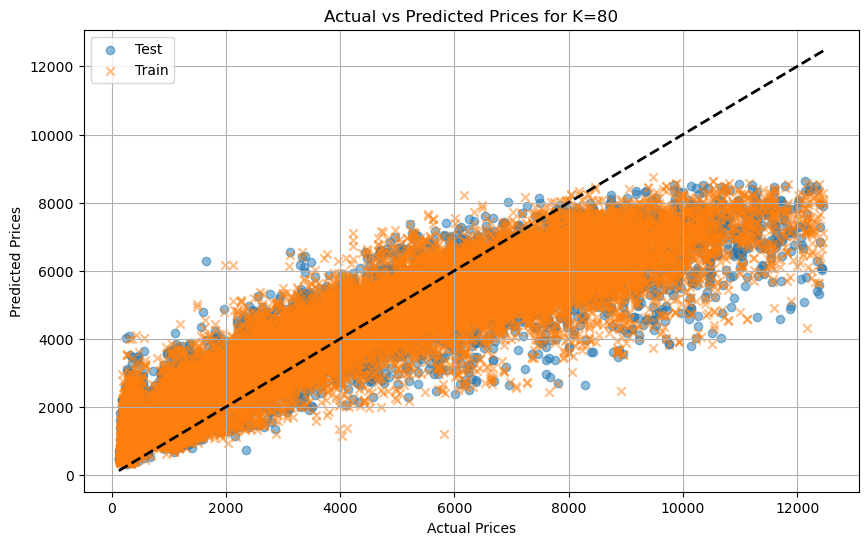

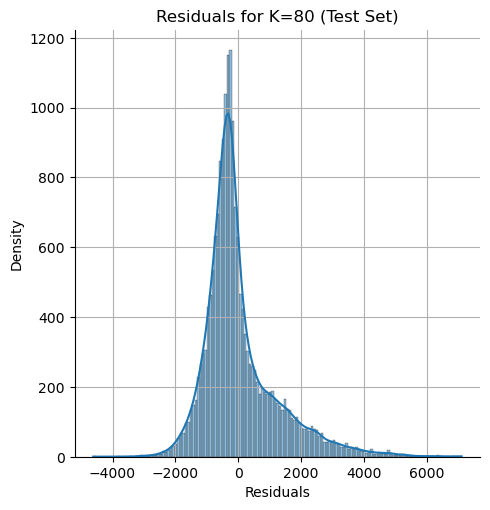

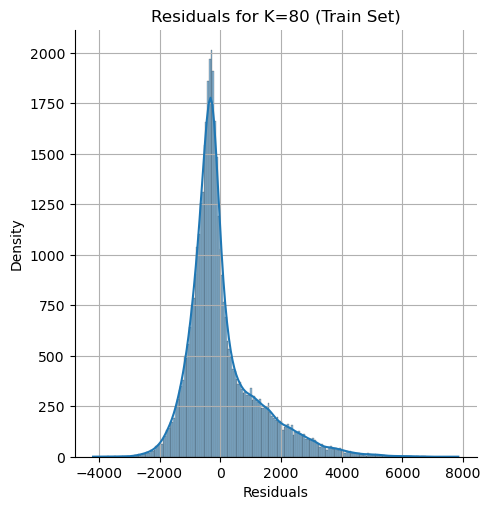

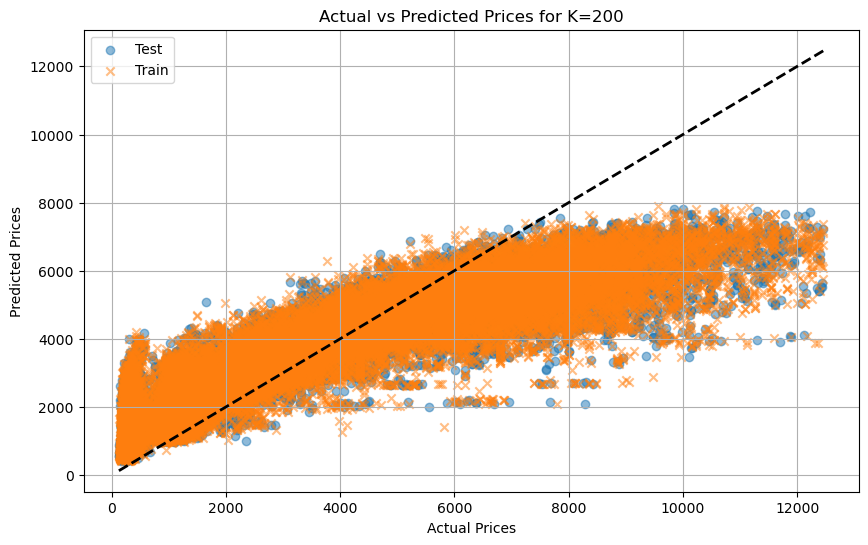

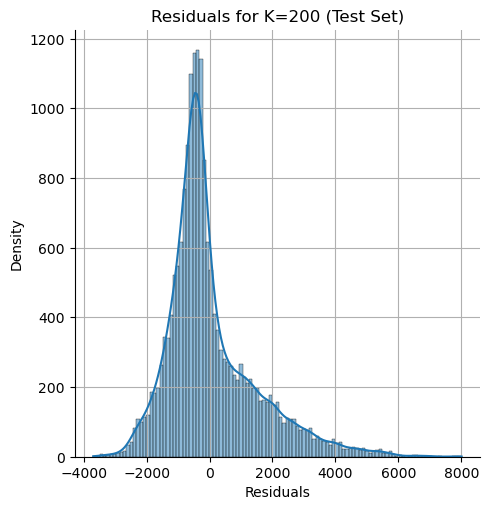

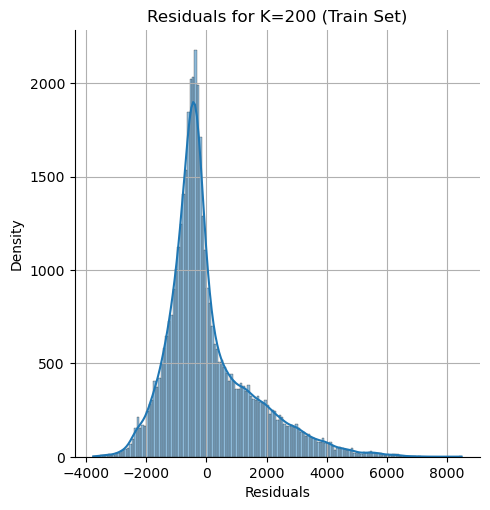

DataFrame: data_wo_features

Test Set Results:
     K  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0    1        4.875747e+05               698.265509           267.085117   
1    3        4.661741e+05               682.769430           380.942512   
2    5        5.098251e+05               714.020351           444.939691   
3   10        6.171220e+05               785.571152           526.953629   
4   50        1.134157e+06              1064.967849           740.520270   
5   80        1.398414e+06              1182.545371           839.018466   
6  200        2.075046e+06              1440.501903          1055.197278   

        R^2  
0  0.939033  
1  0.941709  
2  0.936251  
3  0.922834  
4  0.858183  
5  0.825140  
6  0.740532  
Train Set Results:
     K  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0    1        0.000000e+00                 0.000000             0.000000   
1    3        1.957382e+05               442.423105          

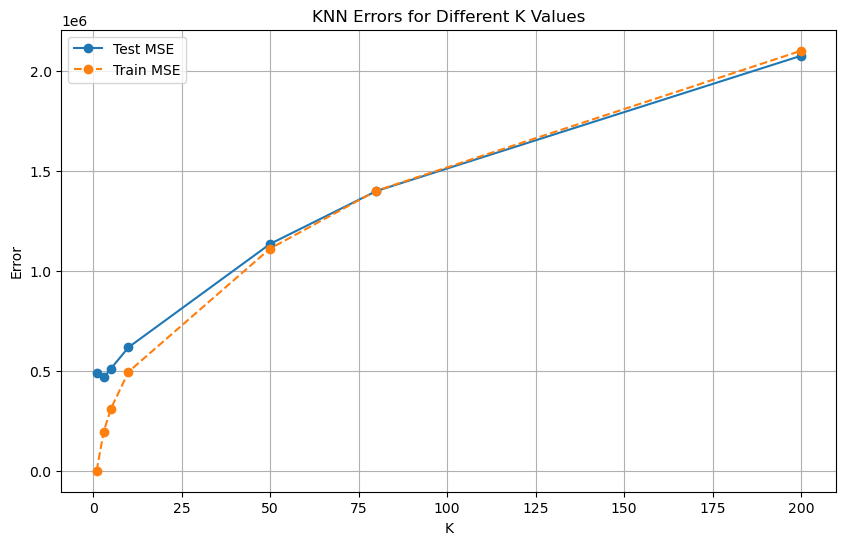

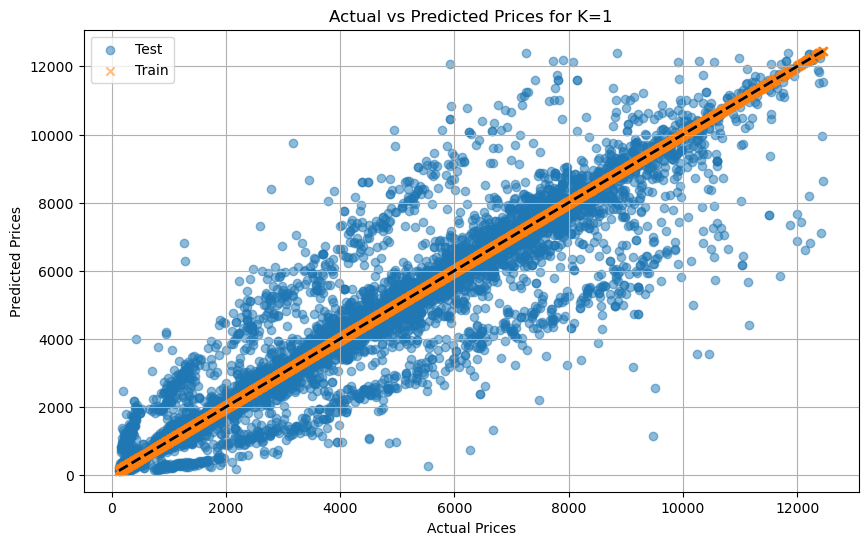

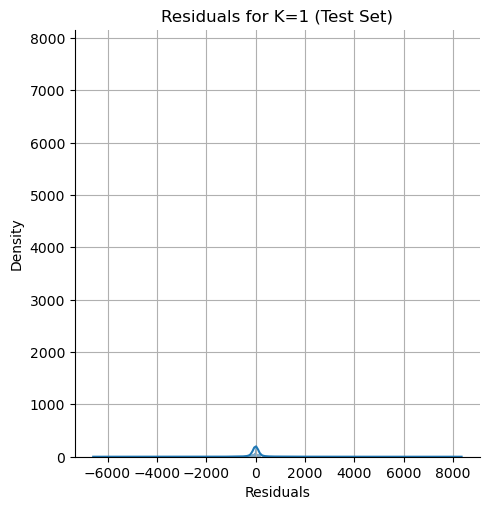

C:\Users\ygastfraind\anaconda3\Lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


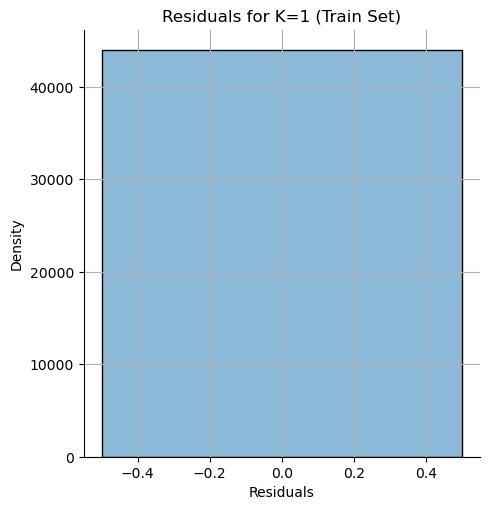

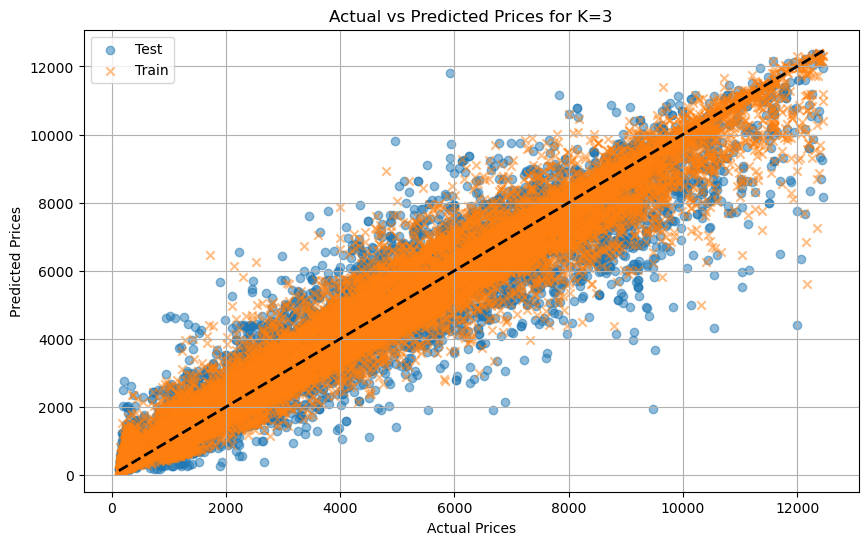

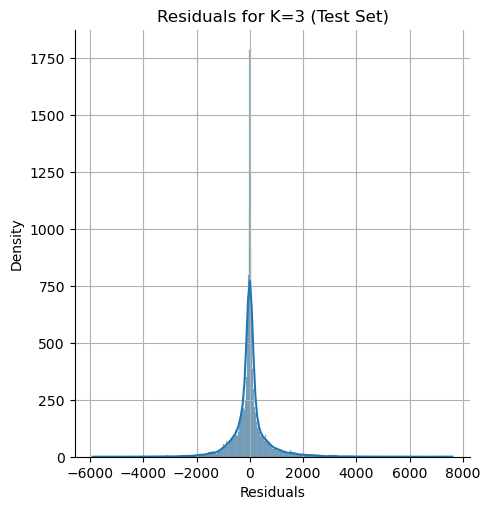

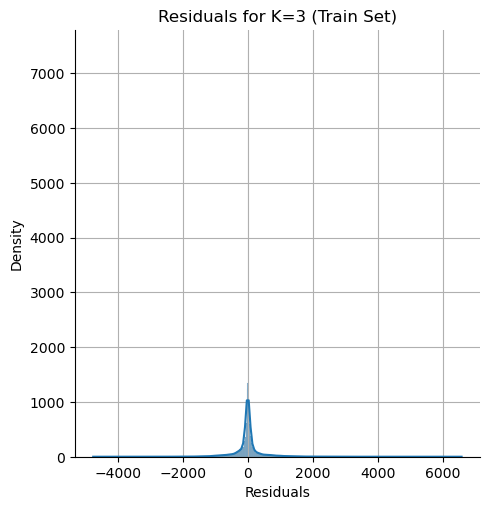

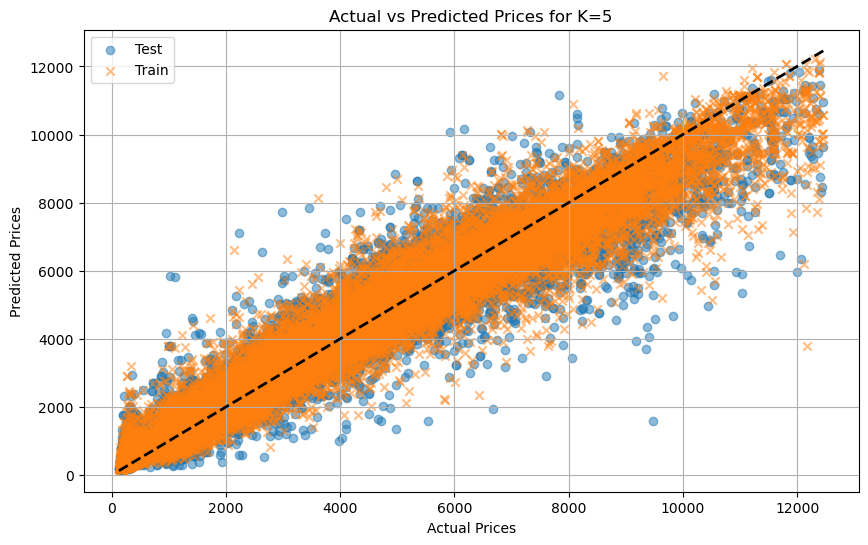

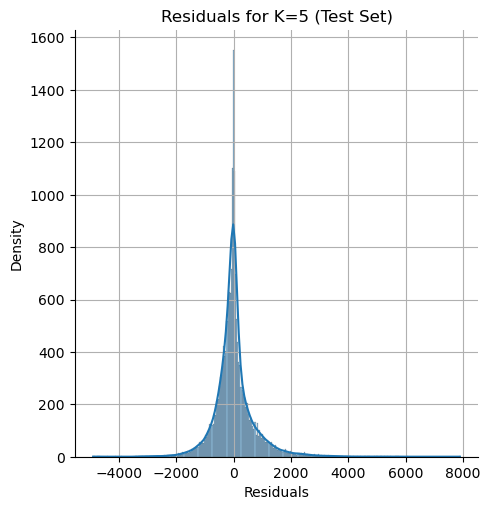

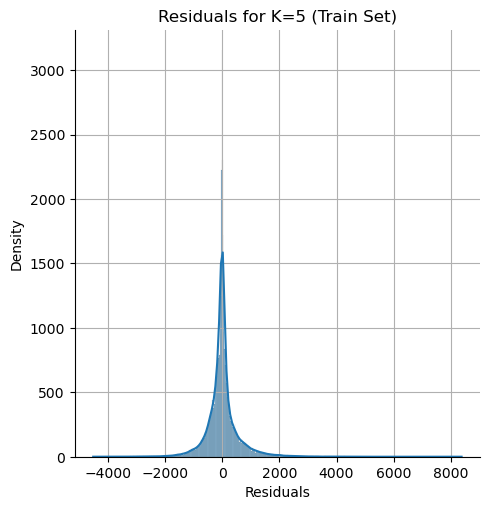

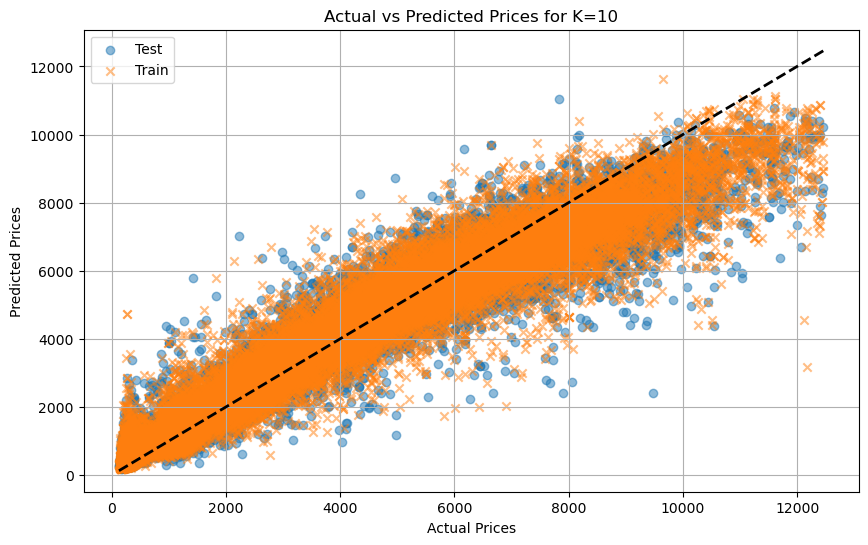

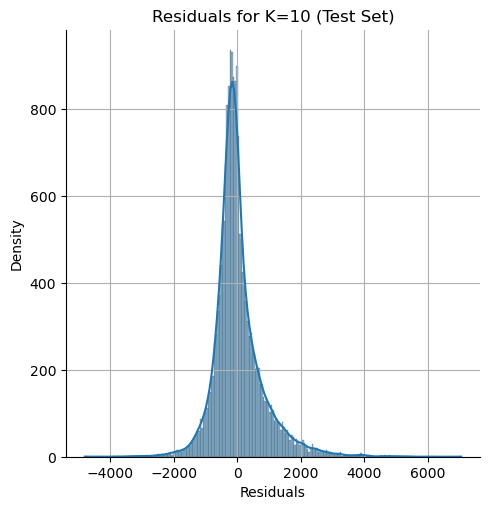

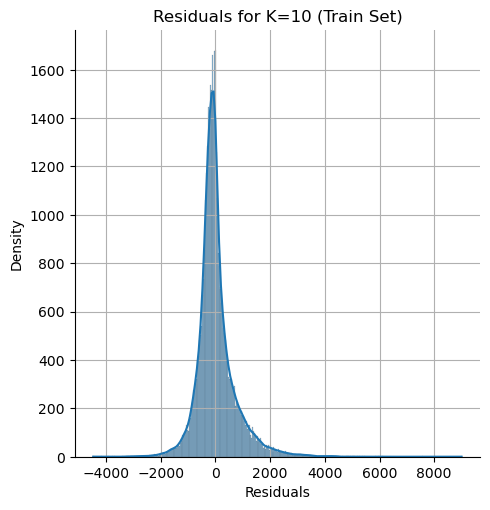

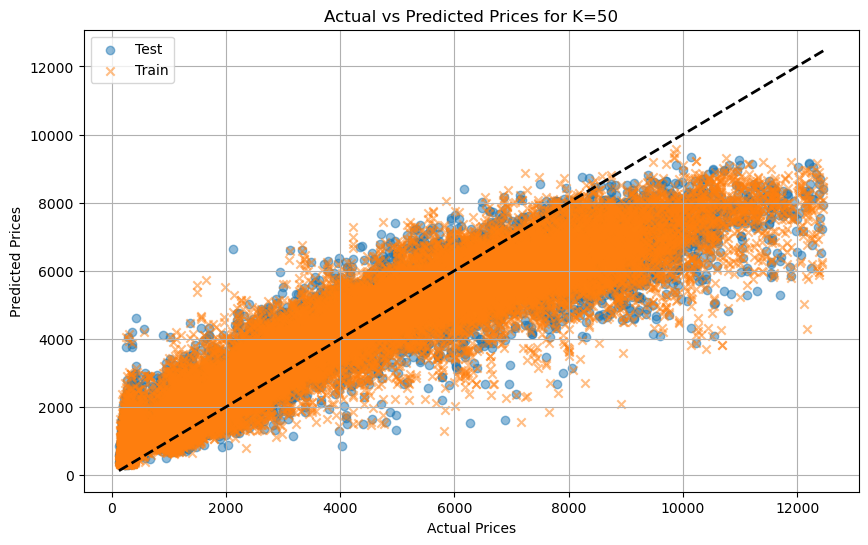

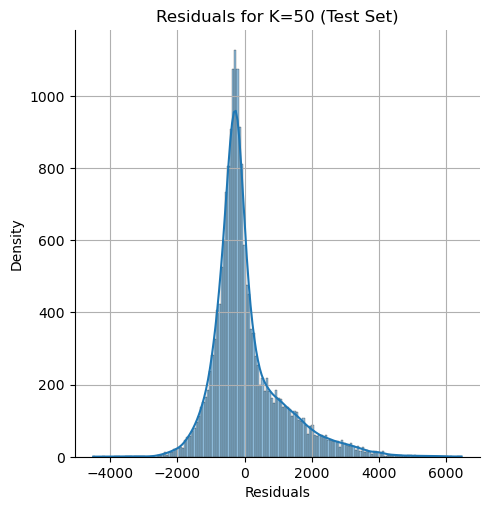

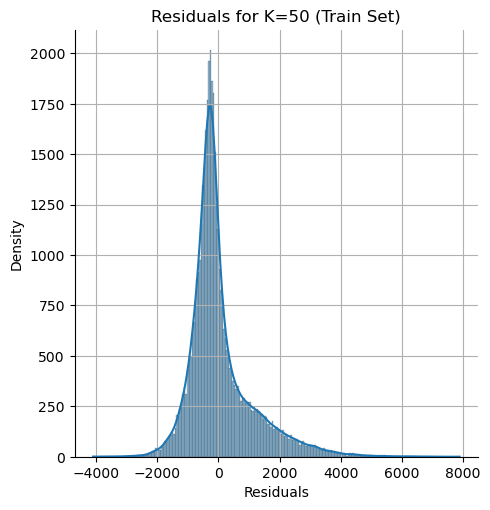

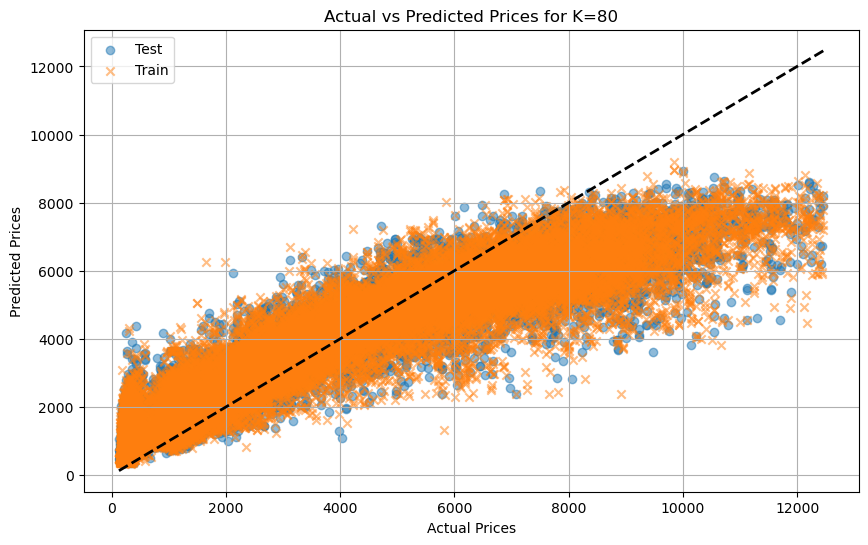

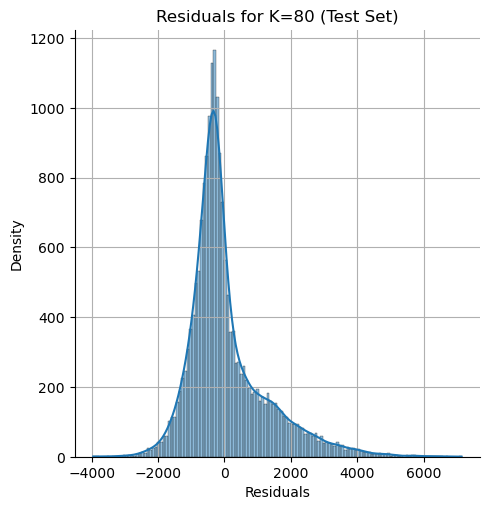

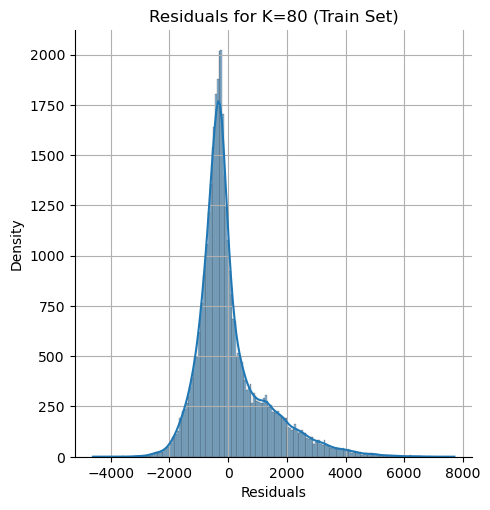

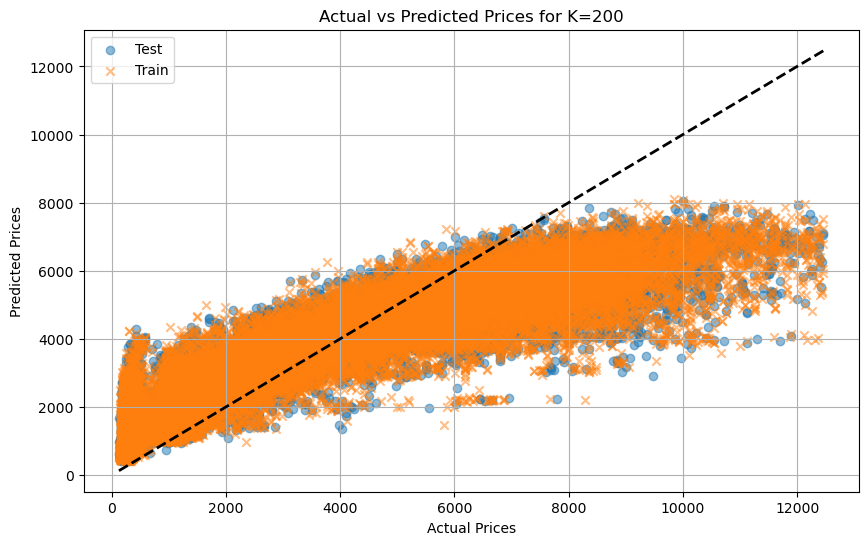

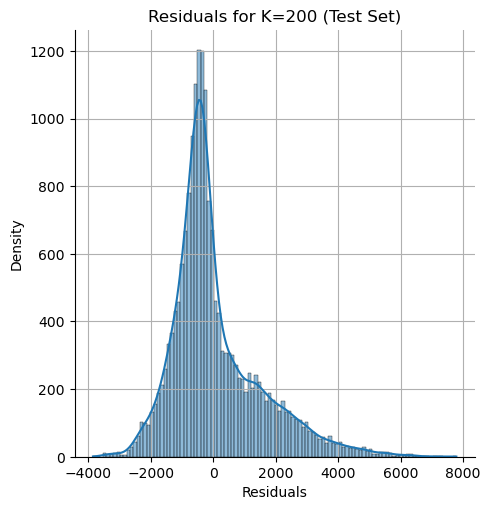

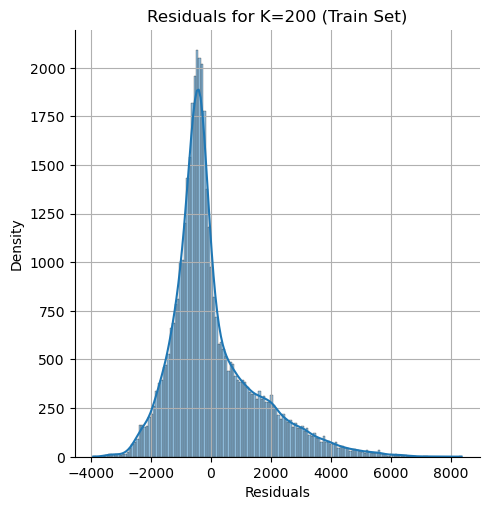

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


data_types = [data_min_max_scaled, data_wo_features]

for df in data_types:
    df_name = next(key for key, value in locals().items() if value is df)
    print(f"DataFrame: {df_name}")
    print()
        
    X = data.drop(columns=['price'])
    y = data['price']

    # Split the data into training and test sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Function to train and evaluate KNN with different K values
    def evaluate_knn(k_values, X_train, y_train, X_test, y_test):
        results = {}
        for k in k_values:
            knn = KNeighborsRegressor(n_neighbors=k)
            knn.fit(X_train, y_train)

            # Evaluate on test set
            y_pred_test = knn.predict(X_test)
            mse_test = mean_squared_error(y_test, y_pred_test)
            rmse_test = np.sqrt(mse_test)
            mae_test = mean_absolute_error(y_test, y_pred_test)
            r2_test = r2_score(y_test, y_pred_test)

            # Evaluate on train set
            y_pred_train = knn.predict(X_train)
            mse_train = mean_squared_error(y_train, y_pred_train)
            rmse_train = np.sqrt(mse_train)
            mae_train = mean_absolute_error(y_train, y_pred_train)
            r2_train = r2_score(y_train, y_pred_train)

            results[k] = {
                'test': {'mse': mse_test, 'rmse': rmse_test, 'mae': mae_test, 'r2': r2_test, 'y_pred': y_pred_test},
                'train': {'mse': mse_train, 'rmse': rmse_train, 'mae': mae_train, 'r2': r2_train, 'y_pred': y_pred_train}
            }
        return results

    k_values = [1, 3, 5, 10, 50, 80, 200]

    # Evaluate KNN with different K values
    results = evaluate_knn(k_values, X_train_scaled, y_train, X_test_scaled, y_test)

    results_df_test = pd.DataFrame([(k, res['test']['mse'], res['test']['rmse'], res['test']['mae'], res['test']['r2']) for k, res in results.items()],
                                   columns=['K', 'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R^2'])

    results_df_train = pd.DataFrame([(k, res['train']['mse'], res['train']['rmse'], res['train']['mae'], res['train']['r2']) for k, res in results.items()],
                                    columns=['K', 'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R^2'])

    print("Test Set Results:")
    print(results_df_test)

    print("Train Set Results:")
    print(results_df_train)

    # Plot the Mean Squared Error for different values of K for test set
    plt.figure(figsize=(10, 6))
    plt.plot(results_df_test['K'], results_df_test['Mean Squared Error'], marker='o', label='Test MSE')
    plt.plot(results_df_train['K'], results_df_train['Mean Squared Error'], marker='o', label='Train MSE', linestyle='--')
    plt.title('KNN Errors for Different K Values')
    plt.xlabel('K')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot scatter plots of actual vs predicted values for each K for both train and test sets
    for k in k_values:
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, results[k]['test']['y_pred'], alpha=0.5, label='Test')
        plt.scatter(y_train, results[k]['train']['y_pred'], alpha=0.5, label='Train', marker='x')
        plt.title(f'Actual vs Predicted Prices for K={k}')
        plt.xlabel('Actual Prices')
        plt.ylabel('Predicted Prices')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot residuals for test set
        residuals_test = y_test - results[k]['test']['y_pred']
        sns.displot(residuals_test, kde=True)
        plt.title(f'Residuals for K={k} (Test Set)')
        plt.xlabel('Residuals')
        plt.ylabel('Density')
        plt.grid(True)
        plt.show()

        # Plot residuals for train set
        residuals_train = y_train - results[k]['train']['y_pred']
        sns.displot(residuals_train, kde=True)
        plt.title(f'Residuals for K={k} (Train Set)')
        plt.xlabel('Residuals')
        plt.ylabel('Density')
        plt.grid(True)
        plt.show()
  

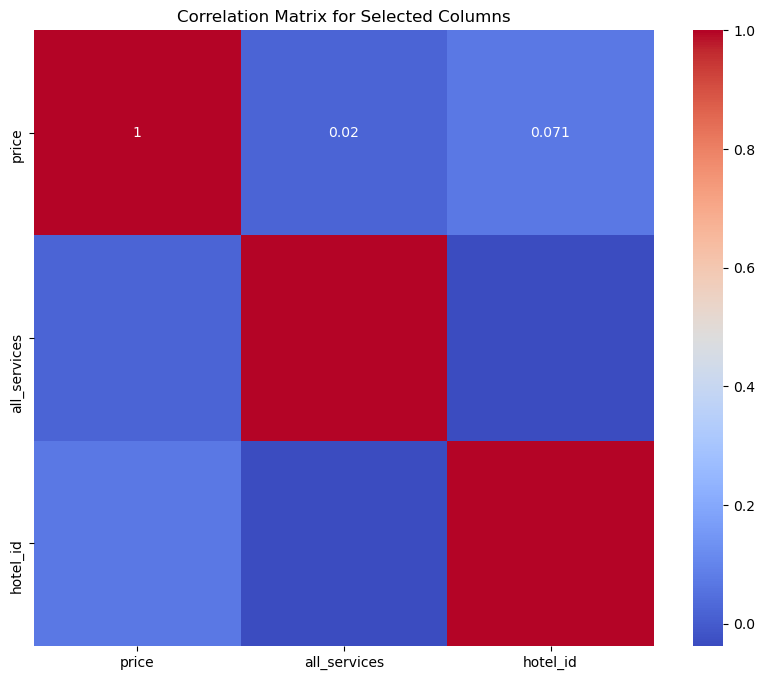

In [12]:
selected_columns = ['price', 'all_services', 'hotel_id']
selected_data = data[selected_columns]
correlation_matrix = selected_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Selected Columns')
plt.show()
